Optimal Eps: 0.5500000000000002, Optimal Min_samples: 3


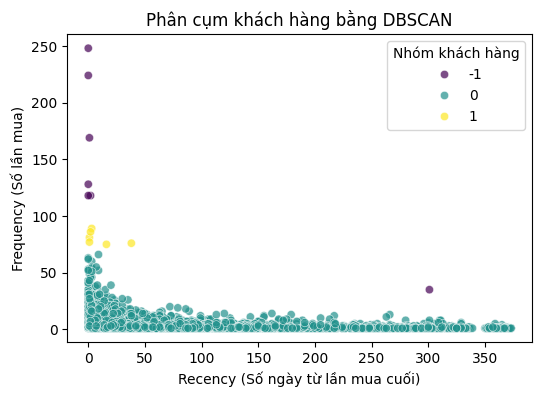

Silhouette Score: 0.83


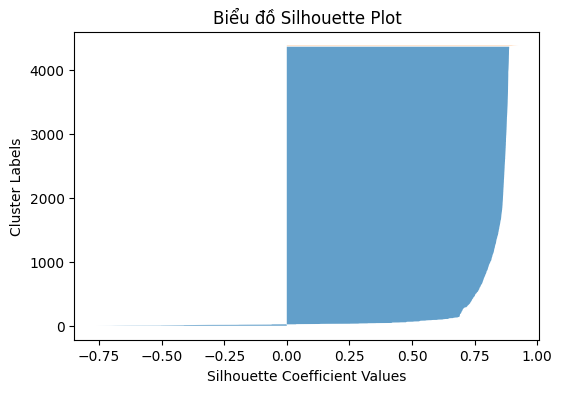

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from itertools import product

# Đọc dữ liệu
file_path = r"C:\Users\PC\Documents\UEH\KPDL\Online Retail.xlsx"
df = pd.read_excel(file_path, sheet_name="Online Retail")

# Loại bỏ các dòng thiếu CustomerID
df = df.dropna(subset=["CustomerID"])
df["CustomerID"] = df["CustomerID"].astype(int)

# Xác định ngày cuối cùng trong tập dữ liệu
max_date = df["InvoiceDate"].max()

# Tính Recency
df_recency = df.groupby("CustomerID")["InvoiceDate"].max().reset_index()
df_recency["Recency"] = (max_date - df_recency["InvoiceDate"]).dt.days
df_recency = df_recency[["CustomerID", "Recency"]]

# Tính Frequency
df_frequency = df.groupby("CustomerID")["InvoiceNo"].nunique().reset_index()
df_frequency.columns = ["CustomerID", "Frequency"]

# Gộp hai bảng lại
rfm_df = df_recency.merge(df_frequency, on="CustomerID")

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df[["Recency", "Frequency"]])

# Tìm giá trị tối ưu cho eps và min_samples bằng GridSearch
eps_values = np.arange(0.1, 1.0, 0.05)
min_samples_values = range(3, 10)
best_score = -1
best_params = None

for eps, min_samples in product(eps_values, min_samples_values):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(rfm_scaled)
    
    # Bỏ các điểm nhiễu (-1) trước khi tính silhouette score
    unique_labels = set(labels)
    if len(unique_labels) > 2:  # Ít nhất 2 cụm thực sự (không tính -1)
        labels_filtered = labels[labels != -1]
        data_filtered = rfm_scaled[labels != -1]
        score = silhouette_score(data_filtered, labels_filtered)
        
        if score > best_score:
            best_score = score
            best_params = (eps, min_samples)

# Áp dụng DBSCAN với tham số tối ưu
if best_params:
    eps_opt, min_samples_opt = best_params
else:
    eps_opt, min_samples_opt = 0.3, 5  # Giá trị mặc định nếu không tìm thấy tham số tốt

# In ra giá trị tối ưu của Eps và Min_samples
print(f"Optimal Eps: {eps_opt}, Optimal Min_samples: {min_samples_opt}")

dbscan = DBSCAN(eps=eps_opt, min_samples=min_samples_opt)
rfm_df["Cluster"] = dbscan.fit_predict(rfm_scaled)

# Vẽ biểu đồ phân cụm
plt.figure(figsize=(6, 4))
sns.scatterplot(data=rfm_df, x="Recency", y="Frequency", hue="Cluster", palette="viridis", alpha=0.7)
plt.xlabel("Recency (Số ngày từ lần mua cuối)")
plt.ylabel("Frequency (Số lần mua)")
plt.title("Phân cụm khách hàng bằng DBSCAN")
plt.legend(title="Nhóm khách hàng")
plt.show()

# Đánh giá phân cụm với Silhouette Score
rfm_filtered = rfm_df[rfm_df["Cluster"] != -1]
if len(rfm_filtered["Cluster"].unique()) > 1:
    silhouette_avg = silhouette_score(rfm_scaled[rfm_df["Cluster"] != -1], rfm_filtered["Cluster"])
    print(f"Silhouette Score: {silhouette_avg:.2f}")
    
    # Vẽ biểu đồ Silhouette Plot
    silhouette_values = silhouette_samples(rfm_scaled[rfm_df["Cluster"] != -1], rfm_filtered["Cluster"])
    plt.figure(figsize=(6, 4))
    y_lower = 10
    for i, cluster in enumerate(np.unique(rfm_filtered["Cluster"])):
        cluster_silhouette_values = silhouette_values[rfm_filtered["Cluster"] == cluster]
        cluster_silhouette_values.sort()
        size_cluster = cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, alpha=0.7)
        y_lower = y_upper + 10
    plt.xlabel("Silhouette Coefficient Values")
    plt.ylabel("Cluster Labels")
    plt.title("Biểu đồ Silhouette Plot")
    plt.show()
else:
    print("Không đủ cụm hợp lệ để tính Silhouette Score.")
